In [1]:
import numpy as np
import sys
import scipy.io as sio  # For reading the matlab .mat format
import pickle as pk
import numpy as np
import pandas as pd
import iisignature as iis
import gudhi
from gudhi import plot_persistence_diagram
from gudhi import plot_persistence_density
from gtda.homology import VietorisRipsPersistence
from gtda.homology import FlagserPersistence
import matplotlib.pyplot as plt
import random
from gtda.diagrams import PersistenceEntropy
from gtda.diagrams import Amplitude
from gudhi.representations.vector_methods import Entropy
from gtda.diagrams import PairwiseDistance
from gtda.plotting import plot_diagram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
%run FUNCTIONS.ipynb

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [5]:
# Allora, qui modifico leggermente quanto fatto nel codice originario in cui considero l'estrazione di serie temporali
# dello stesso dataset, innanzitutto non faccio classificazione sulla path signature o su tutta la Lead matrix, poichè 
# data il numero esiguo di persone il problema potrebbe essere mal condizionato.
# Non utilizzerò nemmeno la random forest per lo stesso motivo, proverò a usare invece la cross validation
# usando il "leave one out"

In [6]:
# Load data in .mat format (rows are time instants, columns are ROI, 116 ARE ROIs)
# (THIS IS A SANTORO FUNCTION)
def load_data_mat(path_single_file):
    file_to_open = path_single_file
    data = sio.loadmat(file_to_open)
    key_data = list(data.keys())[-2]
    data = data[key_data]
    return(data)

In [36]:
# Ora visualizziamo due esempi di series temporali relativi ai due diversi regimi che possiamo avere
# facciamo inoltre una feature selection "ad occhio", considerando la lead matrix

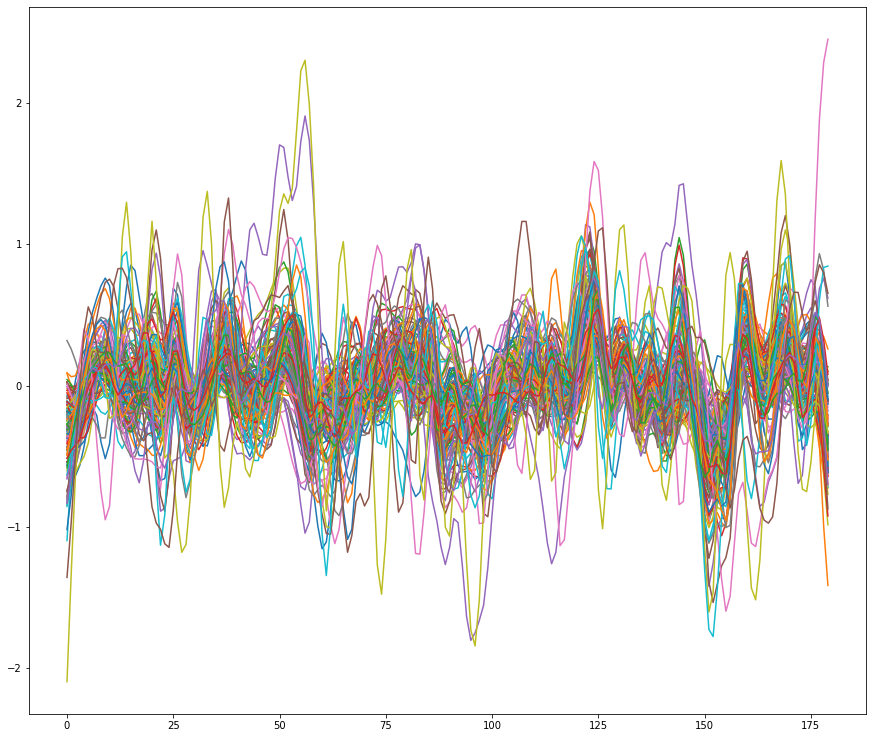

In [37]:
time_series=load_data_mat(f"BP_Timeseries/sub55_EPI_BPaal_timeseries.mat")

plt.figure(figsize=(15,13))
for i in range(116):
    plt.plot(range(180),time_series[:,i])
    
plt.show()

In [38]:
L=lead_matrix_1(time_series)
dgm=rev_directed_mod(L)
plot_diagram(dgm[0])

usetex mode requires TeX.


0.20823798627002288


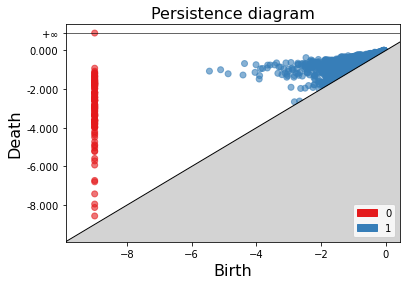

In [39]:
dgm=create_diagram_directly_2(time_series,0.05)
plot_persistence_diagram(dgm)
print(hyper_coherence(time_series,0.05))

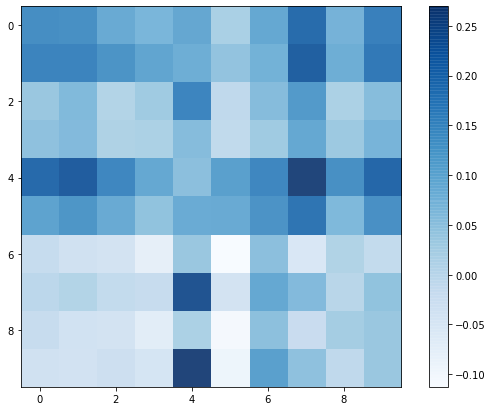

In [40]:
L=lead_matrix_2(time_series)[30:40,90:100]
plt.figure(figsize=(10,7))
plt.imshow(L, alpha=0.9, cmap="Blues")
plt.colorbar()

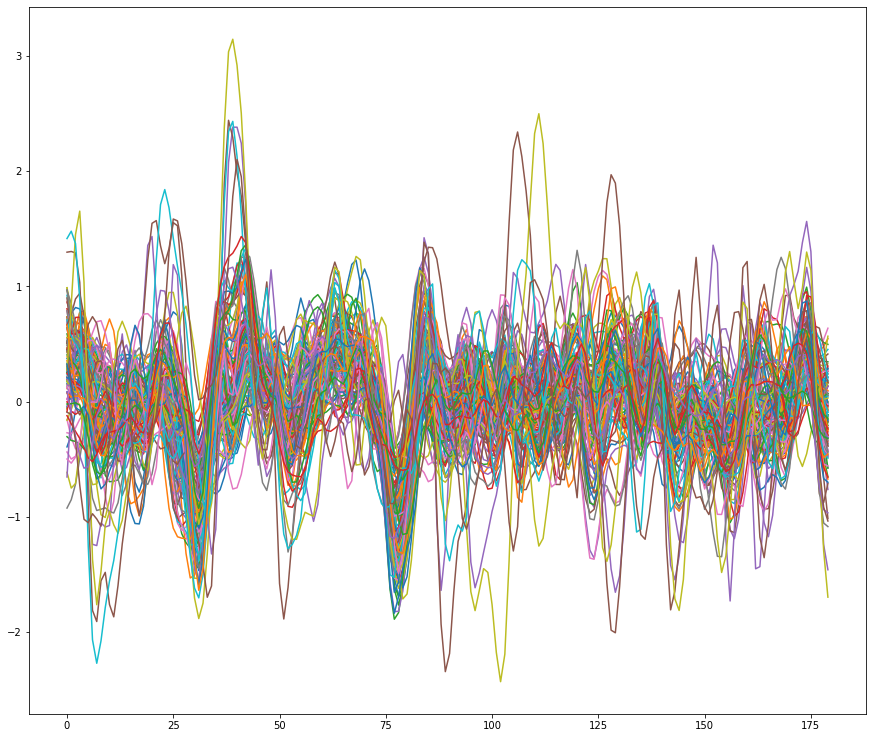

In [41]:
time_series=load_data_mat(f"HC_Timeseries/sub2_EPI_HCaal_timeseries.mat")

plt.figure(figsize=(15,13))
for i in range(116):
    plt.plot(range(180),time_series[:,i])
    
plt.show()

In [42]:
L=lead_matrix_1(time_series)
dgm=rev_directed_mod(L)
plot_diagram(dgm[0])

0.3438215102974828


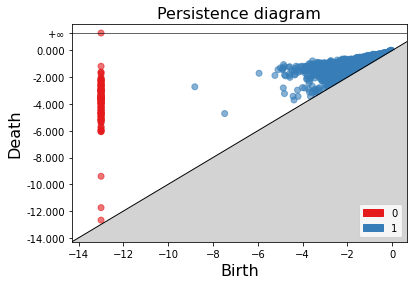

In [43]:
dgm=create_diagram_directly_2(time_series,0.05)
plot_persistence_diagram(dgm)
print(hyper_coherence(time_series,0.05))

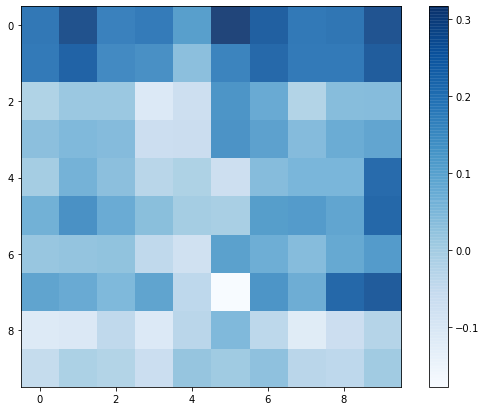

In [44]:
L=lead_matrix_2(time_series)[30:40,90:100]
plt.figure(figsize=(10,7))
plt.imshow(L, alpha=0.9, cmap="Blues")
plt.colorbar()

In [45]:
#  LEAD MATRIX
# selezioniamo più o meno ad occhio il quadrato 30-40,90-100
# ricordiamo che abbiamo bisogno di feature vectors di lunghezza non troppo elevata
# poichè il numero di dati non è molto
Lead_list=list()
labels=[]
for i in range(1,56):
    if not(i==17):
        time_series=load_data_mat(f"BP_Timeseries/sub{i}_EPI_BPaal_timeseries.mat")[5:175,:]
        L=lead_matrix_1(time_series)[30:40,90:100]
        N=L.shape[0]
        feat=[]
        for j in range(N):
            for k in range(j,N):
                if (not j==k):
                    feat.append(L[j,k])
        Lead_list.append(feat)
        labels.append("BP")
        
for i in range(1,66):
    if not(i==33):
        time_series=load_data_mat(f"HC_Timeseries/sub{i}_EPI_HCaal_timeseries.mat")[5:175,:]
        L=lead_matrix_1(time_series)[30:40,90:100]
        N=L.shape[0]
        feat=[]
        for j in range(N):
            for k in range(j,N):
                if (not j==k):
                    feat.append(L[j,k])
        Lead_list.append(feat)
        labels.append("HC")

LEAD=np.array(Lead_list)


In [46]:
LEAD.shape

(118, 45)

In [47]:
# cross validation
sca=StandardScaler()
lr=LogisticRegression()
ppl=Pipeline([('scaler',sca),('clf',lr)])

n_fold=118
cv=KFold(n_fold,shuffle=False)
score_1=cross_val_score(ppl,LEAD,labels,cv=cv,n_jobs=-1)
print(score_1)
print(np.mean(score_1))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.5423728813559322


In [48]:
# Facciamo la classificazione sull'hyper coherence, individuiamo una sliding window pari a 0-100
# HYPERCOHERENCE EARLY
indifference_value=0.05
Hyp1_coh_list=list()
labels=[]
for i in range(1,56):
    if not(i==17):
        time_series=load_data_mat(f"BP_Timeseries/sub{i}_EPI_BPaal_timeseries.mat")[:100,:]
        hyp=hyper_coherence(time_series,indifference_value)
        Hyp1_coh_list.append(hyp)
        labels.append("BP")
        
for i in range(1,66):
    if not(i==33):
        time_series=load_data_mat(f"HC_Timeseries/sub{i}_EPI_HCaal_timeseries.mat")[:100,:]
        hyp=hyper_coherence(time_series,indifference_value)
        Hyp1_coh_list.append(hyp)
        labels.append("HC")

        
HYP1=np.array(Hyp1_coh_list).reshape(-1,1)

In [49]:
# cross validation
sca=StandardScaler()
lr=LogisticRegression()
ppl=Pipeline([('scaler',sca),('clf',lr)])

n_fold=118
cv=KFold(n_fold,shuffle=False)
score_1=cross_val_score(ppl,HYP1,labels,cv=cv,n_jobs=-1)
print(score_1)
print(np.mean(score_1))

[1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0.
 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.
 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1.]
0.6101694915254238


In [50]:
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(HYP1, labels)
model.score(HYP1,labels)

0.576271186440678

In [51]:
# Facciamo la classificazione sull'hyper coherence, individuiamo una sliding window pari a 30-140
# HYPERCOHERENCE MID
indifference_value=0.05
Hyp2_coh_list=list()
labels=[]
for i in range(1,56):
    if not(i==17):
        time_series=load_data_mat(f"BP_Timeseries/sub{i}_EPI_BPaal_timeseries.mat")[30:140,:]
        hyp=hyper_coherence(time_series,indifference_value)
        Hyp2_coh_list.append(hyp)
        labels.append("BP")
        
for i in range(1,66):
    if not(i==33):
        time_series=load_data_mat(f"HC_Timeseries/sub{i}_EPI_HCaal_timeseries.mat")[30:140,:]
        hyp=hyper_coherence(time_series,indifference_value)
        Hyp2_coh_list.append(hyp)
        labels.append("HC")

        
HYP2=np.array(Hyp2_coh_list).reshape(-1,1)

In [52]:
# cross validation
sca=StandardScaler()
lr=LogisticRegression()
ppl=Pipeline([('scaler',sca),('clf',lr)])

n_fold=118
cv=KFold(n_fold,shuffle=False)
score_1=cross_val_score(ppl,HYP2,labels,cv=cv,n_jobs=-1)
print(score_1)
print(np.mean(score_1))

[1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0.
 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1.]
0.6016949152542372


In [53]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(HYP2, labels)
model.score(HYP2,labels)

0.6186440677966102

In [54]:
# Facciamo la classificazione sull'hyper coherence, individuiamo una sliding window pari a 90-180
# HYPERCOHERENCE LAST
indifference_value=0.2
Hyp3_coh_list=list()
labels=[]
for i in range(1,56):
    if not(i==17):
        time_series=load_data_mat(f"BP_Timeseries/sub{i}_EPI_BPaal_timeseries.mat")[90:,:]
        hyp=hyper_coherence(time_series,indifference_value)
        Hyp3_coh_list.append(hyp)
        labels.append("BP")
        
for i in range(1,66):
    if not(i==33):
        time_series=load_data_mat(f"HC_Timeseries/sub{i}_EPI_HCaal_timeseries.mat")[90:,:]
        hyp=hyper_coherence(time_series,indifference_value)
        Hyp3_coh_list.append(hyp)
        labels.append("HC")

        
HYP3=np.array(Hyp3_coh_list).reshape(-1,1)

In [55]:
# cross validation
sca=StandardScaler()
lr=LogisticRegression()
ppl=Pipeline([('scaler',sca),('clf',lr)])

n_fold=118
cv=KFold(n_fold,shuffle=False)
score_1=cross_val_score(ppl,HYP3,labels,cv=cv,n_jobs=-1)
print(score_1)
print(np.mean(score_1))

[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
0.6440677966101694


In [56]:
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(HYP3, labels)
model.score(HYP3,labels)

0.6101694915254238

In [57]:
HYP3

array([[5.31673637e-01],
       [1.09346642e-01],
       [2.52852521e-01],
       [3.73198927e-01],
       [1.09299298e-01],
       [2.77874221e-01],
       [3.16077488e-01],
       [2.83989584e-01],
       [5.48488913e-02],
       [2.18235619e-01],
       [1.25487256e-01],
       [3.52959047e-01],
       [5.01294090e-01],
       [2.80265131e-01],
       [2.93182356e-01],
       [3.55787896e-01],
       [3.35757121e-01],
       [4.37990215e-01],
       [1.78213525e-02],
       [8.28919751e-01],
       [3.87875799e-01],
       [4.59279571e-01],
       [3.50323522e-01],
       [1.10857729e-01],
       [3.34782609e-01],
       [6.01317762e-01],
       [3.95892843e-01],
       [4.25092717e-01],
       [1.33267577e-01],
       [2.24729740e-01],
       [4.32770457e-01],
       [7.54841001e-01],
       [2.17052000e-01],
       [4.73163418e-01],
       [7.53022173e-01],
       [3.48477077e-01],
       [1.34222363e-01],
       [8.26891817e-01],
       [2.76457824e-01],
       [5.86771088e-01],


In [58]:
# Ora consideriamo le grandezze topologiche relative ai clique complexes
# Facciamo la classificazione sull'hyper coherence, individuiamo una sliding window pari a 90-180
# HYPERCOHERENCE LAST
top_dir=list()
labels=[]
for i in range(1,56):
    if not(i==17):
        time_series=load_data_mat(f"BP_Timeseries/sub{i}_EPI_BPaal_timeseries.mat")[90:,:]
        L=lead_matrix_1(time_series)
        dgm_clique=rev_undirected(L)
        PE = PersistenceEntropy()
        pe_feat = PE.fit_transform(dgm_clique)
        A=Amplitude()
        ampl_feat=A.fit_transform(dgm_clique)
        feat1=pe_feat.flatten()
        feat2=ampl_feat.flatten()
        feat=np.concatenate((feat1,feat2), axis=0)
        top_dir.append(feat)
        labels.append("BP")
        
for i in range(1,66):
    if not(i==33):
        time_series=load_data_mat(f"HC_Timeseries/sub{i}_EPI_HCaal_timeseries.mat")[90:,:]
        L=lead_matrix_1(time_series)
        dgm_clique=rev_undirected(L)
        PE = PersistenceEntropy()
        pe_feat = PE.fit_transform(dgm_clique)
        A=Amplitude()
        ampl_feat=A.fit_transform(dgm_clique)
        feat1=pe_feat.flatten()
        feat2=ampl_feat.flatten()
        feat=np.concatenate((feat1,feat2), axis=0)
        top_dir.append(feat)
        labels.append("HC")

        


In [62]:
# cross validation
sca=StandardScaler()
lr=LogisticRegression()
ppl=Pipeline([('scaler',sca),('clf',lr)])

n_fold=118
cv=KFold(n_fold,shuffle=False)
score_1=cross_val_score(ppl,top_dir_arr,labels,cv=cv,n_jobs=-1)
print(score_1)
print(np.mean(score_1))

[0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.]
0.5508474576271186


In [2]:
def entropy_gu_ad(dgm):
    total_0=0
    total_1=0
    l_0=[]
    l_1=[]
    l=len(dgm)
    for i in range(l):
        if dgm[i][0]==1:
            if (not (dgm[i][1][1]==np.inf)):
                length=dgm[i][1][1]-dgm[i][1][0]
                total_1=total_1+length
                l_1.append(length)
        if dgm[i][0]==0:
            if (not (dgm[i][1][1]==np.inf)):
                length=dgm[i][1][1]-dgm[i][1][0]
                total_0=total_0+length
                l_0.append(length)

    log_l_1=np.log(np.array(l_1)/total_1)
    log_l_0=np.log(np.array(l_0)/total_0)
    prod_1=log_l_1*(np.array(l_1)/total_1)
    prod_0=log_l_0*(np.array(l_0)/total_0)
    S_1=-np.sum(prod_1)
    S_0=-np.sum(prod_0)
    return S_0,S_1

def create_diagram_directly_3(mv_time_series, indifferent_value):
    L=lead_matrix_1(mv_time_series)
    T=lead_tensor_1(mv_time_series)
    f=create_filtration_2(L,T,indifferent_value)
    sc=f[0]
    hyp=f[2]
    dgm=sc.persistence()
    return dgm,hyp


In [17]:
# Hyper coherence + entropy

# Facciamo la classificazione sull'hyper coherence, individuiamo una sliding window pari a 30-140
# HYPERCOHERENCE MID
indifferent_value=0.05
Hyp_en_list=list()
labels=[]
for i in range(1,56):
    if not(i==17):
        time_series=load_data_mat(f"BP_Timeseries/sub{i}_EPI_BPaal_timeseries.mat")[30:140,:]
        dgm,hyp=create_diagram_directly_3(time_series,indifferent_value)
        S_0,S_1=entropy_gu_ad(dgm)
        feat=[hyp,S_0,S_1]
        Hyp_en_list.append(feat)
        labels.append("BP")
        
for i in range(1,66):
    if not(i==33):
        time_series=load_data_mat(f"HC_Timeseries/sub{i}_EPI_HCaal_timeseries.mat")[30:140,:]
        dgm,hyp=create_diagram_directly_3(time_series,indifferent_value)
        S_0,S_1=entropy_gu_ad(dgm)
        feat=[hyp,S_0,S_1]
        Hyp_en_list.append(feat)
        labels.append("HC")

        
HYP_EN=np.array(Hyp_en_list).reshape(-1,1)

In [24]:
# cross validation
sca=StandardScaler()
lr=LogisticRegression()
ppl=Pipeline([('scaler',sca),('clf',lr)])

n_fold=118
cv=KFold(n_fold,shuffle=False)
score_1=cross_val_score(ppl,Hyp_en_list,labels,cv=cv,n_jobs=-1)
print(score_1)
print(np.mean(score_1))

[1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1.
 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0.
 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
0.5932203389830508


In [25]:
model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(Hyp_en_list, labels)
model.score(Hyp_en_list,labels)

0.5932203389830508